# Lib

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# CONFIGURATION

In [3]:
class Config:
    DATA_PATH = "robot_dataset.csv"

    INPUT_COLS  = ["x", "y", "z", "roll", "pitch", "yaw"]
    OUTPUT_COLS = ["q1", "q2", "q3", "q4", "q5", "q6"]

    EPOCHS = 200
    BATCH_SIZE = 2048
    LEARNING_RATE = 1e-3

    SCALER_RANGE = (-1, 1)
    RANDOM_STATE = 42

    MODEL_DIR = "models_IK_6in_6out"
    os.makedirs(MODEL_DIR, exist_ok=True)

# LOAD DATA

In [4]:
print("\n[INFO] Loading dataset...")
df = pd.read_csv(Config.DATA_PATH)

X = df[Config.INPUT_COLS].values
Y = df[Config.OUTPUT_COLS].values

print(f"[INFO] Total samples: {X.shape[0]:,}")


[INFO] Loading dataset...
[INFO] Total samples: 1,000,000


# NORMALIZATION

In [5]:
print("\n[INFO] Normalizing data...")

scaler_X = MinMaxScaler(feature_range=Config.SCALER_RANGE)
scaler_Y = MinMaxScaler(feature_range=Config.SCALER_RANGE)

Xn = scaler_X.fit_transform(X)
Yn = scaler_Y.fit_transform(Y)

joblib.dump(scaler_X, f"{Config.MODEL_DIR}/scaler_X.save")
joblib.dump(scaler_Y, f"{Config.MODEL_DIR}/scaler_Y.save")


[INFO] Normalizing data...


['models_IK_6in_6out/scaler_Y.save']

# TRAIN / VAL / TEST SPLIT (70 / 15 / 15)

In [6]:
X_train, X_tmp, Y_train, Y_tmp = train_test_split(
    Xn, Yn, test_size=0.30, random_state=Config.RANDOM_STATE
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_tmp, Y_tmp, test_size=0.50, random_state=Config.RANDOM_STATE
)

print(f"[INFO] Train samples: {X_train.shape[0]:,}")
print(f"[INFO] Val samples  : {X_val.shape[0]:,}")
print(f"[INFO] Test samples : {X_test.shape[0]:,}")

[INFO] Train samples: 700,000
[INFO] Val samples  : 150,000
[INFO] Test samples : 150,000


# MODEL DEFINITION

In [ ]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(len(Config.INPUT_COLS),)),

        layers.Dense(128, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),

        layers.Dense(len(Config.OUTPUT_COLS))
    ])

    model.compile(
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        loss="mse"
    )
    return model


model = build_model()
model.summary()

# CALLBACKS

In [8]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath=f"{Config.MODEL_DIR}/IK_best.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),

    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),

    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

# TRAINING

In [9]:
print("\n[INFO] Training started...\n")

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=Config.EPOCHS,
    batch_size=Config.BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)


[INFO] Training started...

Epoch 1/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2145
Epoch 1: val_loss improved from None to 0.14542, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1797 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 2/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1377
Epoch 2: val_loss improved from 0.14542 to 0.12106, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1315 - val_loss: 0.1211 - learning_rate: 0.0010
Epoch 3/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1172
Epoch 3: val_loss improved from 0.12106 to 0.10850, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1142 - val_loss: 0.1085 - learning_rate: 0.0010
Epoch 4/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1063
Epoch 4: val_loss improved from 0.10850 to 0.10040, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.1045 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 5/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0990
Epoch 5: val_loss improved from 0.10040 to 0.09715, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0982 - val_loss: 0.0972 - learning_rate: 0.0010
Epoch 6/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0943
Epoch 6: val_loss improved from 0.09715 to 0.09338, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0940 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 7/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0918
Epoch 7: val_loss improved from 0.09338 to 0.09014, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0914 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 8/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0891
Epoch 8: val_loss improved from 0.09014 to 0.08773, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0888 - val_loss: 0.0877 - learning_rate: 0.0010
Epoch 9/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0875
Epoch 9: val_loss improved from 0.08773 to 0.08666, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0875 - val_loss: 0.0867 - learning_rate: 0.0010
Epoch 10/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0866
Epoch 10: val_loss improved from 0.08666 to 0.08632, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0860 - val_loss: 0.0863 - learning_rate: 0.0010
Epoch 11/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0846
Epoch 11: val_loss improved from 0.08632 to 0.08532, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0848 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 12/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0833
Epoch 12: val_loss improved from 0.08532 to 0.08454, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0835 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 13/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0823
Epoch 13: val_loss did not improve from 0.08454
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0826 - val_loss: 0.0856 - learning_rate: 0.0010
Epoch 14/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0821
Epoch 14: val_loss improved from 0.08454 to 0.08353, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0823 - val_loss: 0.0835 - learning_rate: 0.0010
Epoch 15/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0815
Epoch 15: val_loss improved from 0.08353 to 0.08129, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0816 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 16/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0804
Epoch 16: val_loss did not improve from 0.08129
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0808 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 17/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0802
Epoch 17: val_loss did not improve from 0.08129
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0804 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 18/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0803
Epoch 18: val_loss did not improve from 0.08129
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0798 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 19/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0788
Epoch 19: val_loss improved from 0.08129 to 0.08038, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0789 - val_loss: 0.0804 - learning_rate: 0.0010
Epoch 20/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0783
Epoch 20: val_loss improved from 0.08038 to 0.07887, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0786 - val_loss: 0.0789 - learning_rate: 0.0010
Epoch 21/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0787
Epoch 21: val_loss did not improve from 0.07887
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0785 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 22/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0782
Epoch 22: val_loss did not improve from 0.07887
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0780 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 23/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0776
Epoch 23: val_loss improved from 0.07887 to 0.07868, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0777 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 24/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0772
Epoch 24: val_loss improved from 0.07868 to 0.07773, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0775 - val_loss: 0.0777 - learning_rate: 0.0010
Epoch 25/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0765
Epoch 25: val_loss did not improve from 0.07773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0770 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 26/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0763
Epoch 26: val_loss did not improve from 0.07773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0766 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 27/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0763
Epoch 27: val_loss did not improve from 0.07773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0762 - val_loss: 0.0790 - learning_rate: 0.0010
Epoch 28/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0766
Epoch 28: val_loss did not improve from 0.07773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0766 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 29/200
340/342 ━━━━━━━

342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0761 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 30/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0754
Epoch 30: val_loss did not improve from 0.07693
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0758 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 31/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0756
Epoch 31: val_loss did not improve from 0.07693
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0757 - val_loss: 0.0777 - learning_rate: 0.0010
Epoch 32/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0750
Epoch 32: val_loss improved from 0.07693 to 0.07679, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0752 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 33/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0747
Epoch 33: val_loss did not improve from 0.07679
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0749 - val_loss: 0.0776 - learning_rate: 0.0010
Epoch 34/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0744
Epoch 34: val_loss did not improve from 0.07679
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0749 - val_loss: 0.0785 - learning_rate: 0.0010
Epoch 35/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0746
Epoch 35: val_loss did not improve from 0.07679
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0749 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 36/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0738
Epoch 36: val_loss improved from 0.07679 to 0.07676, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0743 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 37/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0743
Epoch 37: val_loss did not improve from 0.07676
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0746 - val_loss: 0.0777 - learning_rate: 0.0010
Epoch 38/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0742
Epoch 38: val_loss did not improve from 0.07676
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0742 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 39/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0743
Epoch 39: val_loss improved from 0.07676 to 0.07670, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0741 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 40/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0735
Epoch 40: val_loss did not improve from 0.07670
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0741 - val_loss: 0.0771 - learning_rate: 0.0010
Epoch 41/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0735
Epoch 41: val_loss improved from 0.07670 to 0.07629, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0734 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 42/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0730
Epoch 42: val_loss improved from 0.07629 to 0.07592, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0734 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 43/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0734
Epoch 43: val_loss did not improve from 0.07592
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0734 - val_loss: 0.0777 - learning_rate: 0.0010
Epoch 44/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0735
Epoch 44: val_loss did not improve from 0.07592
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0735 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 45/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0734
Epoch 45: val_loss improved from 0.07592 to 0.07374, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0732 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 46/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0721
Epoch 46: val_loss did not improve from 0.07374
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0726 - val_loss: 0.0761 - learning_rate: 0.0010
Epoch 47/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0731
Epoch 47: val_loss did not improve from 0.07374
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0734 - val_loss: 0.0749 - learning_rate: 0.0010
Epoch 48/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0726
Epoch 48: val_loss did not improve from 0.07374
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0727 - val_loss: 0.0751 - learning_rate: 0.0010
Epoch 49/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0722
Epoch 49: val_loss did not improve from 0.07374
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0724 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 50/200
342/342 ━━━━━━━

342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0678 - val_loss: 0.0715 - learning_rate: 5.0000e-04
Epoch 57/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0671
Epoch 57: val_loss improved from 0.07152 to 0.07133, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0674 - val_loss: 0.0713 - learning_rate: 5.0000e-04
Epoch 58/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0671
Epoch 58: val_loss did not improve from 0.07133
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0672 - val_loss: 0.0716 - learning_rate: 5.0000e-04
Epoch 59/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0672
Epoch 59: val_loss improved from 0.07133 to 0.07126, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0672 - val_loss: 0.0713 - learning_rate: 5.0000e-04
Epoch 60/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0669
Epoch 60: val_loss did not improve from 0.07126
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0673 - val_loss: 0.0717 - learning_rate: 5.0000e-04
Epoch 61/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0670
Epoch 61: val_loss improved from 0.07126 to 0.07124, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0672 - val_loss: 0.0712 - learning_rate: 5.0000e-04
Epoch 62/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0672
Epoch 62: val_loss improved from 0.07124 to 0.07107, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0672 - val_loss: 0.0711 - learning_rate: 5.0000e-04
Epoch 63/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0672
Epoch 63: val_loss did not improve from 0.07107
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0671 - val_loss: 0.0716 - learning_rate: 5.0000e-04
Epoch 64/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0668
Epoch 64: val_loss did not improve from 0.07107
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0669 - val_loss: 0.0711 - learning_rate: 5.0000e-04
Epoch 65/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0665
Epoch 65: val_loss improved from 0.07107 to 0.07098, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0668 - val_loss: 0.0710 - learning_rate: 5.0000e-04
Epoch 66/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0667
Epoch 66: val_loss improved from 0.07098 to 0.07057, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0669 - val_loss: 0.0706 - learning_rate: 5.0000e-04
Epoch 67/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0663
Epoch 67: val_loss did not improve from 0.07057
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0666 - val_loss: 0.0706 - learning_rate: 5.0000e-04
Epoch 68/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0664
Epoch 68: val_loss did not improve from 0.07057
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0666 - val_loss: 0.0712 - learning_rate: 5.0000e-04
Epoch 69/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0665
Epoch 69: val_loss did not improve from 0.07057
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0665 - val_loss: 0.0716 - learning_rate: 5.0000e-04
Epoch 70/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0664
Epoch 70: val_loss did not improve from 0.07057
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0665 - val_loss: 0.0708 - learning_rate: 5.0000e-04
Epoch 71

342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0636 - val_loss: 0.0692 - learning_rate: 2.5000e-04
Epoch 78/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0632
Epoch 78: val_loss improved from 0.06916 to 0.06906, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0635 - val_loss: 0.0691 - learning_rate: 2.5000e-04
Epoch 79/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0631
Epoch 79: val_loss did not improve from 0.06906
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0633 - val_loss: 0.0694 - learning_rate: 2.5000e-04
Epoch 80/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0632
Epoch 80: val_loss improved from 0.06906 to 0.06893, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0634 - val_loss: 0.0689 - learning_rate: 2.5000e-04
Epoch 81/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0632
Epoch 81: val_loss did not improve from 0.06893
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0634 - val_loss: 0.0694 - learning_rate: 2.5000e-04
Epoch 82/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0632
Epoch 82: val_loss did not improve from 0.06893
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0633 - val_loss: 0.0698 - learning_rate: 2.5000e-04
Epoch 83/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0630
Epoch 83: val_loss did not improve from 0.06893
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0633 - val_loss: 0.0694 - learning_rate: 2.5000e-04
Epoch 84/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0631
Epoch 84: val_loss improved from 0.06893 to 0.06877, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0632 - val_loss: 0.0688 - learning_rate: 2.5000e-04
Epoch 85/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0630
Epoch 85: val_loss did not improve from 0.06877
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0631 - val_loss: 0.0691 - learning_rate: 2.5000e-04
Epoch 86/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0628
Epoch 86: val_loss did not improve from 0.06877
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0631 - val_loss: 0.0691 - learning_rate: 2.5000e-04
Epoch 87/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0630
Epoch 87: val_loss did not improve from 0.06877
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0631 - val_loss: 0.0691 - learning_rate: 2.5000e-04
Epoch 88/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0628
Epoch 88: val_loss did not improve from 0.06877
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0630 - val_loss: 0.0695 - learning_rate: 2.5000e-04
Epoch 89

342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0615 - val_loss: 0.0682 - learning_rate: 1.2500e-04
Epoch 96/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0612
Epoch 96: val_loss did not improve from 0.06821
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0614 - val_loss: 0.0682 - learning_rate: 1.2500e-04
Epoch 97/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0614
Epoch 97: val_loss did not improve from 0.06821
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0614 - val_loss: 0.0684 - learning_rate: 1.2500e-04
Epoch 98/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0611
Epoch 98: val_loss did not improve from 0.06821
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0613 - val_loss: 0.0684 - learning_rate: 1.2500e-04
Epoch 99/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0611
Epoch 99: val_loss did not improve from 0.06821
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0614 - val_loss: 0.0685 - learning_rate: 1.2500e-04
Epoch 10

342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0614 - val_loss: 0.0682 - learning_rate: 1.2500e-04
Epoch 101/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0612
Epoch 101: val_loss did not improve from 0.06816
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0613 - val_loss: 0.0682 - learning_rate: 1.2500e-04
Epoch 102/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0611
Epoch 102: val_loss did not improve from 0.06816
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0613 - val_loss: 0.0683 - learning_rate: 1.2500e-04
Epoch 103/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0611
Epoch 103: val_loss did not improve from 0.06816
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0612 - val_loss: 0.0684 - learning_rate: 1.2500e-04
Epoch 104/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0612
Epoch 104: val_loss did not improve from 0.06816
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0612 - val_loss: 0.0684 - learning_rate: 1.2500e-04


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0606 - val_loss: 0.0679 - learning_rate: 6.2500e-05
Epoch 107/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0604
Epoch 107: val_loss improved from 0.06793 to 0.06785, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0605 - val_loss: 0.0678 - learning_rate: 6.2500e-05
Epoch 108/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0604
Epoch 108: val_loss did not improve from 0.06785
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0605 - val_loss: 0.0680 - learning_rate: 6.2500e-05
Epoch 109/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0603
Epoch 109: val_loss did not improve from 0.06785
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0605 - val_loss: 0.0679 - learning_rate: 6.2500e-05
Epoch 110/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0606
Epoch 110: val_loss did not improve from 0.06785
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0604 - val_loss: 0.0680 - learning_rate: 6.2500e-05
Epoch 111/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0604
Epoch 111: val_loss did not improve from 0.06785
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0605 - val_loss: 0.0679 - learning_rate: 6.2500e-05


342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0601 - val_loss: 0.0678 - learning_rate: 3.1250e-05
Epoch 118/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0599
Epoch 118: val_loss did not improve from 0.06778
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0600 - val_loss: 0.0678 - learning_rate: 3.1250e-05
Epoch 119/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0599
Epoch 119: val_loss did not improve from 0.06778
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0600 - val_loss: 0.0679 - learning_rate: 3.1250e-05
Epoch 120/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0599
Epoch 120: val_loss did not improve from 0.06778
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0600 - val_loss: 0.0678 - learning_rate: 3.1250e-05
Epoch 121/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0598
Epoch 121: val_loss did not improve from 0.06778
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0600 - val_loss: 0.0678 - learning_rate: 3.1250e-05


342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0598 - val_loss: 0.0677 - learning_rate: 1.5625e-05
Epoch 129/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0599
Epoch 129: val_loss improved from 0.06774 to 0.06773, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0598 - val_loss: 0.0677 - learning_rate: 1.5625e-05
Epoch 130/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0597
Epoch 130: val_loss did not improve from 0.06773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0598 - val_loss: 0.0677 - learning_rate: 1.5625e-05
Epoch 131/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0598
Epoch 131: val_loss did not improve from 0.06773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0598 - val_loss: 0.0678 - learning_rate: 1.5625e-05
Epoch 132/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0596
Epoch 132: val_loss did not improve from 0.06773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0598 - val_loss: 0.0678 - learning_rate: 1.5625e-05
Epoch 133/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0598
Epoch 133: val_loss did not improve from 0.06773
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0597 - val_loss: 0.0677 - learning_rate: 1.5625e-05



Epoch 137: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0597 - val_loss: 0.0677 - learning_rate: 1.5625e-05
Epoch 138/200
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0596
Epoch 138: val_loss improved from 0.06772 to 0.06772, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06
Epoch 139/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0597
Epoch 139: val_loss improved from 0.06772 to 0.06772, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06
Epoch 140/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0596
Epoch 140: val_loss improved from 0.06772 to 0.06771, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06
Epoch 141/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0597
Epoch 141: val_loss improved from 0.06771 to 0.06770, saving model to models_IK_6in_6out/IK_best.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06
Epoch 142/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0597
Epoch 142: val_loss did not improve from 0.06770
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06
Epoch 143/200
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0596
Epoch 143: val_loss did not improve from 0.06770
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06
Epoch 144/200
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0596
Epoch 144: val_loss did not improve from 0.06770
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06
Epoch 145/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0596
Epoch 145: val_loss did not improve from 0.06770
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0596 - val_loss: 0.0677 - learning_rate: 7.8125e-06


# TEST & METRICS (RMSE + R²)

In [10]:
print("\n[INFO] Evaluating model on test set...")

Y_pred_n = model.predict(X_test, verbose=0)

Y_pred = scaler_Y.inverse_transform(Y_pred_n)
Y_true = scaler_Y.inverse_transform(Y_test)

print("\n========== PER-JOINT METRICS ==========")

rmse_list, r2_list = [], []

for i, joint in enumerate(Config.OUTPUT_COLS):
    rmse = np.sqrt(mean_squared_error(Y_true[:, i], Y_pred[:, i]))
    r2 = r2_score(Y_true[:, i], Y_pred[:, i])

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"{joint:>3}: RMSE = {rmse:.6f} rad | R² = {r2*100:.2f}%")


print("\n========== OVERALL METRICS ==========")
print(f"Mean RMSE: {np.mean(rmse_list):.6f} rad")
print(f"Mean R²  : {np.mean(r2_list)*100:.2f}%")


[INFO] Evaluating model on test set...

========== PER-JOINT METRICS ==========
 q1: RMSE = 0.173245 rad | R² = 99.09%
 q2: RMSE = 0.646279 rad | R² = 49.38%
 q3: RMSE = 0.646236 rad | R² = 49.14%
 q4: RMSE = 0.540847 rad | R² = 91.12%
 q5: RMSE = 0.119434 rad | R² = 98.26%
 q6: RMSE = 0.275617 rad | R² = 90.78%

========== OVERALL METRICS ==========
Mean RMSE: 0.400276 rad
Mean R²  : 79.63%


# Plot

In [11]:
def plot_predictions(Y_true, Y_pred, n_points=50000, title_prefix="Test"):
    # Convert to numpy if DataFrame
    if isinstance(Y_true, pd.DataFrame):
        Y_true_np = Y_true.values
    else:
        Y_true_np = Y_true

    if isinstance(Y_pred, pd.DataFrame):
        Y_pred_np = Y_pred.values
    else:
        Y_pred_np = Y_pred

    # Random sample
    n_points = min(n_points, Y_true_np.shape[0])
    idx = np.random.choice(Y_true_np.shape[0], n_points, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.ravel()

    for j in range(6):
        axes[j].scatter(
            Y_true_np[idx, j],
            Y_pred_np[idx, j],
            s=0.5,
            color="#1f77b4"
        )

        # Diagonal reference line
        min_val = min(Y_true_np[idx, j].min(), Y_pred_np[idx, j].min())
        max_val = max(Y_true_np[idx, j].max(), Y_pred_np[idx, j].max())

        axes[j].plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

        axes[j].set_title(f"{title_prefix} q{j+1}: Pred vs True")
        axes[j].set_xlabel("True")
        axes[j].set_ylabel("Predicted")
        axes[j].grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()


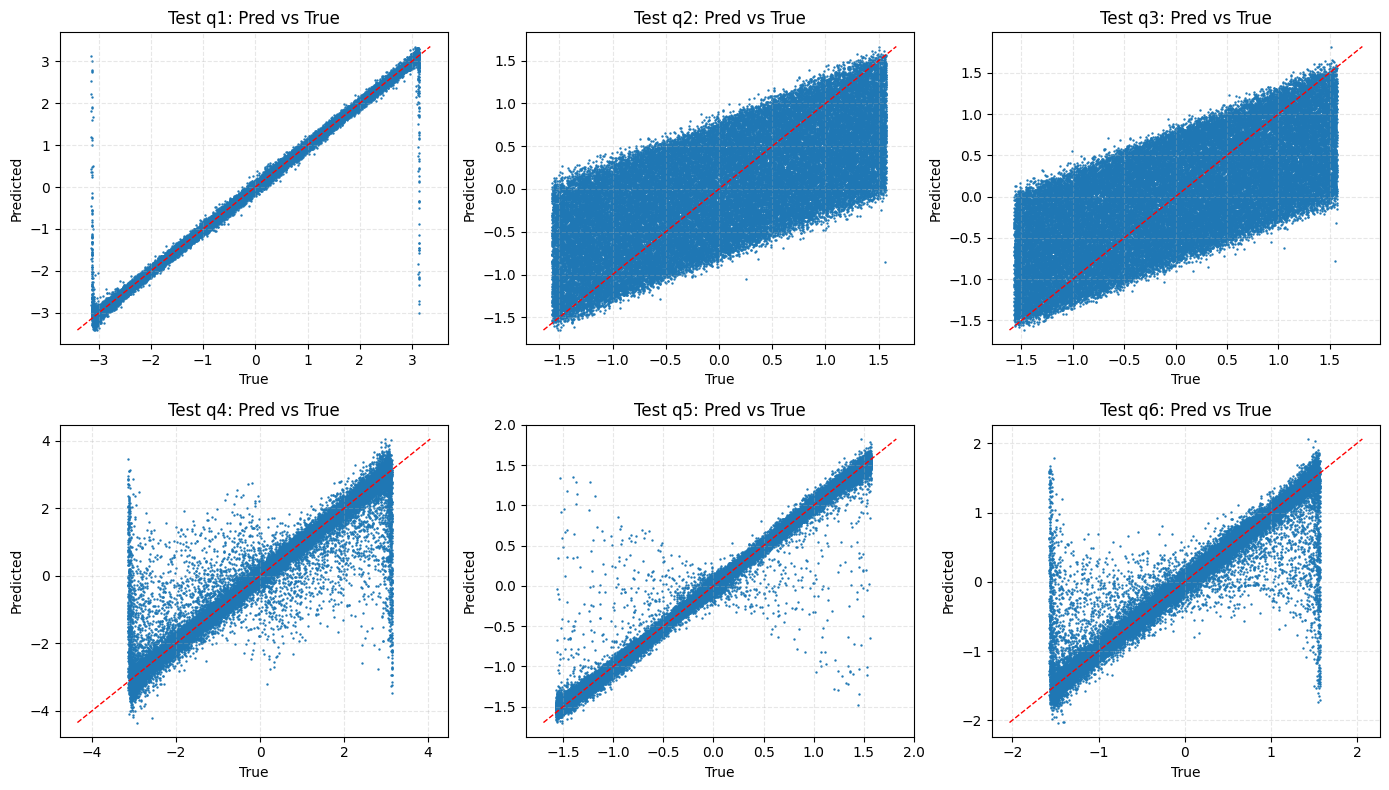

In [12]:
plot_predictions(Y_true, Y_pred, n_points=50000, title_prefix="Test")

# CONFIGURATION OF FILTERD DATA

In [13]:
class Config:
    DATA_PATH = "robot_dataset_filtered.csv"

    INPUT_COLS  = ["x", "y", "z", "roll", "pitch", "yaw"]
    OUTPUT_COLS = ["q1", "q2", "q3", "q4", "q5", "q6"]

    EPOCHS = 100
    BATCH_SIZE = 2048
    LEARNING_RATE = 1e-3

    SCALER_RANGE = (-1, 1)
    RANDOM_STATE = 42

    MODEL_DIR = "models_IK_6in_6out_filterd"
    os.makedirs(MODEL_DIR, exist_ok=True)

# LOAD FILTERD DATA

In [14]:
print("\n[INFO] Loading dataset...")
df = pd.read_csv(Config.DATA_PATH)

X = df[Config.INPUT_COLS].values
Y = df[Config.OUTPUT_COLS].values

print(f"[INFO] Total samples: {X.shape[0]:,}")


[INFO] Loading dataset...
[INFO] Total samples: 154,961


# NORMALIZATION

In [15]:
print("\n[INFO] Normalizing data...")

scaler_X = MinMaxScaler(feature_range=Config.SCALER_RANGE)
scaler_Y = MinMaxScaler(feature_range=Config.SCALER_RANGE)

Xn = scaler_X.fit_transform(X)
Yn = scaler_Y.fit_transform(Y)

joblib.dump(scaler_X, f"{Config.MODEL_DIR}/scaler_X.save")
joblib.dump(scaler_Y, f"{Config.MODEL_DIR}/scaler_Y.save")


[INFO] Normalizing data...


['models_IK_6in_6out_filterd/scaler_Y.save']

# TRAIN / VAL / TEST SPLIT (70 / 15 / 15)

In [16]:
X_train, X_tmp, Y_train, Y_tmp = train_test_split(
    Xn, Yn, test_size=0.30, random_state=Config.RANDOM_STATE
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_tmp, Y_tmp, test_size=0.50, random_state=Config.RANDOM_STATE
)

print(f"[INFO] Train samples: {X_train.shape[0]:,}")
print(f"[INFO] Val samples  : {X_val.shape[0]:,}")
print(f"[INFO] Test samples : {X_test.shape[0]:,}")

[INFO] Train samples: 108,472
[INFO] Val samples  : 23,244
[INFO] Test samples : 23,245


# TRAINING FILTERED DATA

In [37]:
print("\n[INFO] Training started...\n")

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=Config.EPOCHS,
    batch_size=128,
    verbose=1
)


[INFO] Training started...

Epoch 1/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0590 - val_loss: 0.0639
Epoch 2/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0589 - val_loss: 0.0639
Epoch 3/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0589 - val_loss: 0.0639
Epoch 4/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0589 - val_loss: 0.0639
Epoch 5/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0588 - val_loss: 0.0639
Epoch 6/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0588 - val_loss: 0.0639
Epoch 7/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0588 - val_loss: 0.0639
Epoch 8/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0588 - val_loss: 0.0639
Epoch 9/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0588 - val_loss: 0.0639
Epoch 10/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0588 - val_loss: 0.0639
Epoch 11/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0588 - val_loss: 0.0639
Epoch 12/100

# TEST & METRICS (RMSE + R²)

In [38]:
print("\n[INFO] Evaluating model on test set...")

Y_pred_n = model.predict(X_test, verbose=0)

Y_pred = scaler_Y.inverse_transform(Y_pred_n)
Y_true = scaler_Y.inverse_transform(Y_test)

print("\n========== PER-JOINT METRICS ==========")

rmse_list, r2_list = [], []

for i, joint in enumerate(Config.OUTPUT_COLS):
    rmse = np.sqrt(mean_squared_error(Y_true[:, i], Y_pred[:, i]))
    r2 = r2_score(Y_true[:, i], Y_pred[:, i])

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"{joint:>3}: RMSE = {rmse:.6f} rad | R² = {r2*100:.2f}%")


print("\n========== OVERALL METRICS ==========")
print(f"Mean RMSE: {np.mean(rmse_list):.6f} rad")
print(f"Mean R²  : {np.mean(r2_list)*100:.2f}%")


[INFO] Evaluating model on test set...

========== PER-JOINT METRICS ==========
 q1: RMSE = 0.154219 rad | R² = 99.28%
 q2: RMSE = 0.404757 rad | R² = 75.71%
 q3: RMSE = 0.399955 rad | R² = 20.78%
 q4: RMSE = 0.450511 rad | R² = 93.83%
 q5: RMSE = 0.137861 rad | R² = 98.13%
 q6: RMSE = 0.226174 rad | R² = 93.80%

========== OVERALL METRICS ==========
Mean RMSE: 0.295579 rad
Mean R²  : 80.26%


# PLOT FILTERED DATA

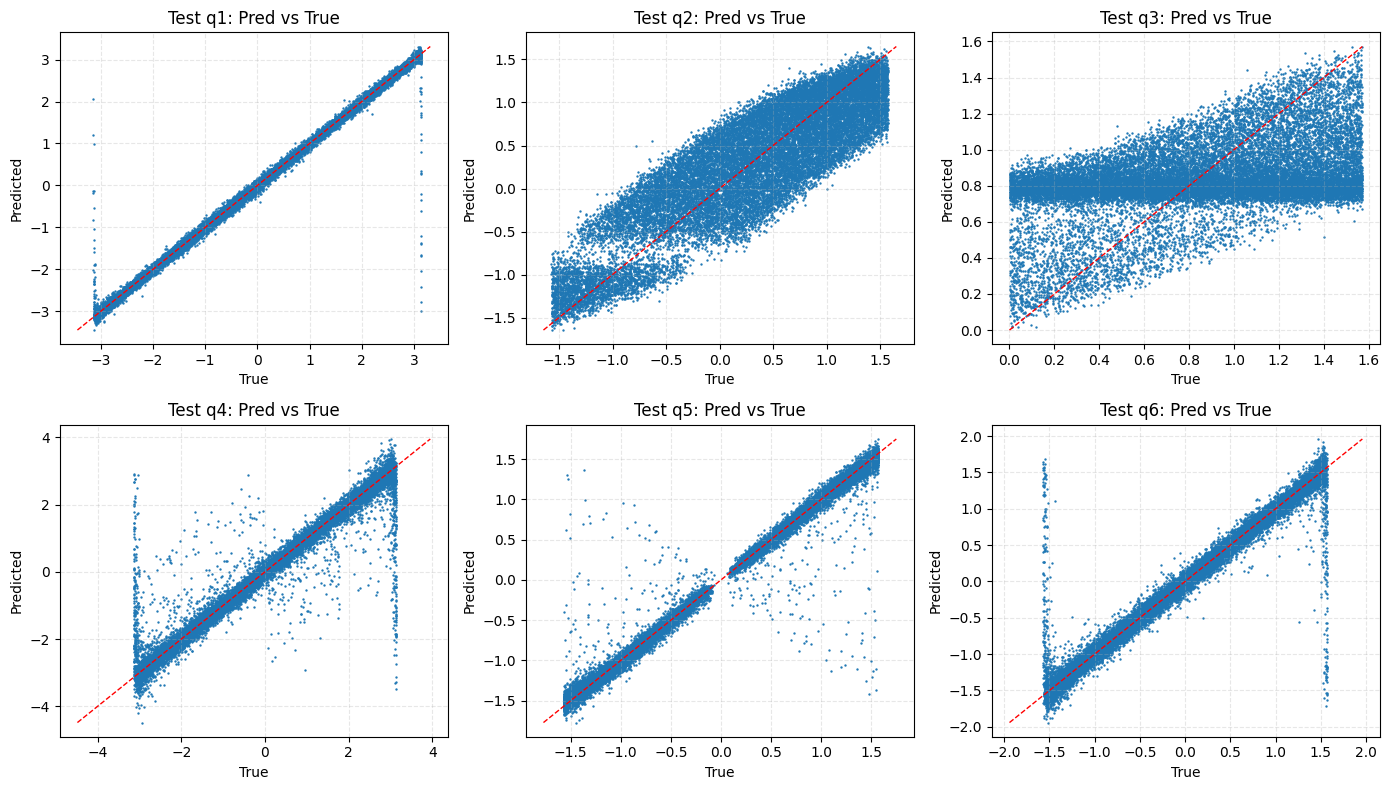

In [39]:
plot_predictions(Y_true, Y_pred, n_points=50000, title_prefix="Test")

# SAVE FINAL MODEL

In [40]:
final_path = f"{Config.MODEL_DIR}/IK_6in_6out_FINAL.h5"
model.save(final_path)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "input_scaler.pkl")

print(f"\n[INFO] Model saved at: {final_path}")


[INFO] Model saved at: models_IK_6in_6out_filterd/IK_6in_6out_FINAL.h5
